### Overview
- This code contains a number of independent cells to analyse the available data. 
- In each cell, the data is re-loaded file-by-file and stored temporarily as an xarray dataset. This approach, rather than loading all files into a single xarray is far less computationally expensive, which is important given we are working with tens-of-thousands of images.

In [1]:
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
import torch
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.geometry as sgeom
import random

Each cell / group of cells runs independently, loading file in file_list to avoid storing all in memory simultaneously

In [2]:
data_path = r"lustre_scratch/data/original_data/absolute" # dir where data is stored
plot_path = "plots/" # dir to store plots 
sample_percent = 1
## locate files and load into single dataset 
file_list = []
N_files = len(os.listdir(data_path))
sample_indices = random.sample(range(N_files), int(N_files*sample_percent))

for index in sample_indices:
    if os.listdir(data_path)[index].endswith('.nc'):
        file_path = os.path.join(data_path, os.listdir(data_path)[index])
        file_list.append(file_path)
N_pixels = 48
ds_sample = xr.open_dataset(file_list[0])

### Check Temperature Values
Ensure temperatures are within a physical range (270-310K) i.e. no outliers emerged from data analysis. Find max, min, mean and plot in histogram. 

In [ ]:
mean_array = []
min_array = []
max_array = []
for file in file_list: 
    ds = xr.open_dataset(file)
    mean_array.append(ds.gRsst.mean(dim={'x','y'}))
    min_array.append(ds.gRsst.min(dim={'x','y'}))
    max_array.append(ds.gRsst.max(dim={'x','y'}))
mean_array = xr.concat(mean_array, dim='i')
min_array = xr.concat(min_array, dim='i')
max_array = xr.concat(max_array, dim='i')
fig, ax = plt.subplots(1,3)
ax[0].hist(mean_array)
ax[0].set_title('Min')
ax[0].set_ylabel('Counts')
ax[1].hist(min_array)
ax[1].set_title('Max')
ax[1].set_xlabel('Temperature (K)')
ax[2].hist(max_array)
ax[2].set_title('Mean')
plt.tight_layout()
fig.savefig(plot_path + 'Temperature_dist')
plt.show()

### Correlation in absolute field
This section, and the next (*Correlation in gradient field*) are aimed to show that there is more disparity in the gradient domains between the smooth L4 and gradient-restored L4 images. Thus, it is favourable to train the model in the gradient domain.

In [ ]:
## Plot absolute field example  
fig, ax = plt.subplots(1,2)
randint = np.random.randint(len(ds_sample.gRsst))
ax[0].imshow(ds_sample.sstL4[randint].data)
ax[0].set_title('L4')
ax[0].set_xlabel('Image Pixels')
im = ax[1].imshow(ds_sample.gRsst[randint].data)
ax[1].set_title('Gradient Restored L4')
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label = 'Temperature, K')
fig.suptitle(r'1 pixel = 0.05$^o$ $\approx$ 5km', y = 0.9)
plt.savefig(plot_path + 'absolute_field')

In [3]:
## find correlation in absolute field 
absolute_corr = []
for file in file_list: 
    ds = xr.open_dataset(file)
    absolute_corr.append(xr.corr(ds.gRsst, ds.sstL4, dim={'x','y'}))
absolute_corr = xr.concat(absolute_corr, dim='i')
absolute_corr.attrs['units'] = 'PPCC'
## will plot alongside gradient corr

### Correlation in gradient field

In [ ]:
## Plot gradient example 
gRsst_x_grad = ds_sample.gRsst.differentiate('x').data
gRsst_y_grad = ds_sample.gRsst.differentiate('y').data
gRsst_grad = (gRsst_x_grad**2 + gRsst_y_grad**2)**(1/2)
sstL4_x_grad = ds_sample.sstL4.differentiate('x').data
sstL4_y_grad = ds_sample.sstL4.differentiate('y').data
sstL4_grad = (sstL4_x_grad**2 + sstL4_y_grad**2)**(1/2)
fig, ax = plt.subplots(1,2)
randint = np.random.randint(len(sstL4_x_grad))
ax[0].imshow(sstL4_grad[randint])
ax[0].set_title('sstL4')
ax[1].imshow(gRsst_grad[randint])
ax[1].set_title('gRsst')
fig.suptitle('Gradient Field', y = 0.88)
plt.savefig(plot_path + 'grad_comparison.png')

In [4]:
## Find grad corr 
grad_corr = []
for file in file_list: 
    ds = xr.open_dataset(file)
    gRsst_x_grad = ds.gRsst.differentiate('x')
    gRsst_y_grad = ds.gRsst.differentiate('y')
    gRsst_grad = (gRsst_x_grad**2 + gRsst_y_grad**2)**(1/2)
    sstL4_x_grad = ds.sstL4.differentiate('x')
    sstL4_y_grad = ds.sstL4.differentiate('y')
    sstL4_grad = (sstL4_x_grad**2 + sstL4_y_grad**2)**(1/2)
    grad_corr.append(xr.corr(sstL4_grad, gRsst_grad, dim={'x','y'}))
grad_corr = xr.concat(grad_corr, dim='i')

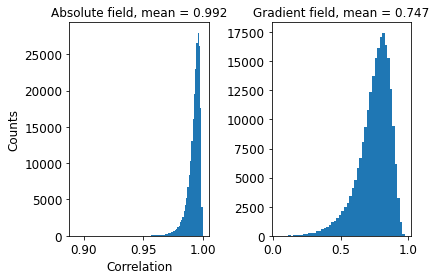

In [6]:
## Plot alongside absolute field corr
fig,ax = plt.subplots(1,2)

ax[0].hist(absolute_corr.data, bins = 100)
ax[0].set_xlabel('Correlation',fontsize=12)
ax[0].set_ylabel('Counts',fontsize=12)
ax[0].set_title(f'Absolute field, mean = {np.round(absolute_corr.mean().data,3)}')

ax[1].hist(grad_corr.data, bins = 50)
ax[1].set_title(f'Gradient field, mean = {np.round(grad_corr.mean().data,3)}')

ax[0].tick_params(axis='both', labelsize=12) 
ax[1].tick_params(axis='both', labelsize=12) 

fig.tight_layout()
fig.savefig('plots/final_plots/data_correlations.png',dpi=1400)
plt.show()

### Gradient Distribution
Find distribution of gradients in data, with the values flattened into a 1D array for a histogram plot. The aim is to demonstrate that the data exists between [-1,1], with some outliers that can be clipped. 

In [9]:
## collect all x_gradient and y_gradient values into arrays for histogram plot
gRsst_grad_values = []
sstL4_grad_values = []
N_data = 0
clipping = True
for file in file_list:
    ds = xr.open_dataset(file)
    N_data += len(ds.i)
    gRsst_x_grad = ds.gRsst.differentiate('x')
    gRsst_y_grad = ds.gRsst.differentiate('y')
    sstL4_x_grad = ds.sstL4.differentiate('x')
    sstL4_y_grad = ds.sstL4.differentiate('y')
    if clipping:
        gRsst_x_grad = gRsst_x_grad.clip(-1,1)
        gRsst_y_grad = gRsst_y_grad.clip(-1,1)
        sstL4_x_grad = sstL4_x_grad.clip(-1,1)
        sstL4_y_grad = sstL4_y_grad.clip(-1,1)
    gRsst_grad_values.append(gRsst_y_grad.stack(dim={'i','x','y'}).data)
    gRsst_grad_values.append(gRsst_x_grad.stack(dim={'i','x','y'}).data)
    sstL4_grad_values.append(sstL4_x_grad.stack(dim={'i','x','y'}).data)
    sstL4_grad_values.append(sstL4_y_grad.stack(dim={'i','x','y'}).data)
gRsst_grad_values = np.concatenate(gRsst_grad_values)
sstL4_grad_values = np.concatenate(sstL4_grad_values)

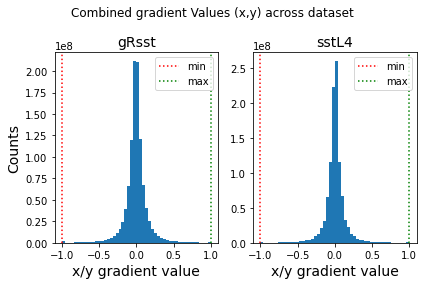

In [10]:
fig, ax = plt.subplots(1,2)
ax[0].hist(gRsst_grad_values, bins = 50)
ax[0].set_title('gRsst',fontsize=14)
ax[0].set_ylabel('Counts',fontsize=14)
ax[0].set_xlabel('x/y gradient value',fontsize=14)
ax[0].axvline(np.min(gRsst_grad_values), ls = ':', color = 'red', label = 'min')
ax[0].axvline(np.max(gRsst_grad_values), ls = ':', color = 'green', label = 'max')
ax[0].legend()
ax[1].hist(sstL4_grad_values, bins = 50)
ax[1].set_xlabel('x/y gradient value',fontsize=14)
ax[1].axvline(np.min(sstL4_grad_values), ls = ':', color = 'red', label = 'min')
ax[1].axvline(np.max(sstL4_grad_values), ls = ':', color = 'green', label = 'max')
ax[1].set_title('sstL4',fontsize=14)
ax[1].legend()
fig.suptitle(f'Combined gradient Values (x,y) across dataset')
fig.tight_layout()
fig.savefig('plots/final_plots/gradient_values_clipped.png',dpi=1400)

### Data Spatial Distribution
Find the location of each data point, and assign to a lat/lon subgrid. Plot over a world map. Note that this code is slow, especially when performed across the entire data.

done


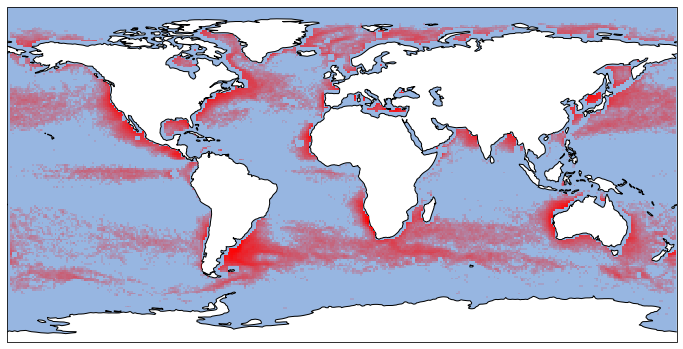

In [3]:
x_min = -180
x_max = 180
y_min = -90
y_max = 90

fig = plt.figure(figsize=(12,24))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)

colour = "#00FF0010"

# record the number of scenes that fall into each (y,x) box
counts = {}

# track the maximum number of scenes in any bin
max_count = 0

# define the bin size in degrees
sz=1

n = ds_sample.x.shape[0]
for file in file_list:
    ds = xr.open_dataset(file)
    ds_c = xr.Dataset({"y": ds.centre.sel(s=0),
                    "x": ds.centre.sel(s=1)}) # lat/lon of each tile centre
    eastings = ds_c.x
    northings = ds_c.y
    n = eastings.shape[0]
    
    for i in range(0,n):
        # for each scene bin the x,y coordinates
        grid_x_min = round(float(eastings[i]+sz/2)/sz)*sz
        grid_y_min = round(float(northings[i]+sz/2)/sz)*sz

        # update the count for this bin
        if (grid_y_min,grid_x_min) not in counts:
            counts[(grid_y_min,grid_x_min)] = 0
        count = counts[(grid_y_min, grid_x_min)] + 1
        if count > max_count:
            max_count = count
        counts[(grid_y_min,grid_x_min)] = count
# for each bin, plot a rectangle on the map
for (y,x) in counts:
    count = counts[(y,x)]
    # define a red colour with transparency (alpha channel) based on the count
    col = "#FF0000%02X"%(int(255*(np.log(count)/np.log(max_count))))
    polygon = sgeom.Polygon(shell=[(x-sz/2,y-sz/2),(x-sz/2,y+sz/2),(x+sz/2,y+sz/2),(x+sz/2,y-sz/2)])
    ax.add_geometries([polygon], ccrs.PlateCarree(),facecolor=col)

plt.savefig(plot_path + "spatial_distribution.png", dpi=1400)
fig.show()
print('done')

### Data Temporal Distribution
Show that the data is consistently distributed across time. 

In [ ]:
time = []
for file in file_list: 
    ds = xr.open_dataset(file)
    time.append(ds.time)
time = xr.concat(time, dim='i')
time_sorted = time.sortby(time)

# Calculate cumulative count of data points
cumulative_count = range(1, len(time_sorted) + 1)
# this will be plotted against time_sorted

plt.figure(figsize=(10, 6))
plt.plot(time_sorted, cumulative_count, marker='o', linestyle='-',ms=0.1)
plt.xlabel('Time')
plt.ylabel('Cumulative Count of Data Points')
plt.title('Cumulative Number of Data Points as a Function of Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(plot_path + 'time_distribution')
plt.show()


### Previous/Next Day

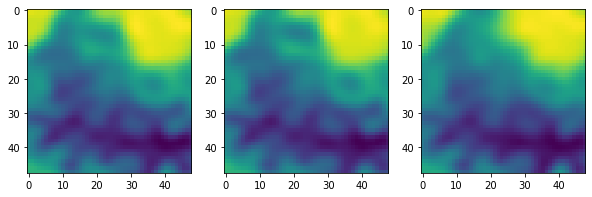

In [3]:
## plot random example of previous / next day data
ds = xr.open_dataset('lustre_scratch/data/data_v2/l3_blended_l4_extracts_gR_201701day_v2.nc')
randint = np.random.randint(len(ds.sstL4))
fig, ax = plt.subplots(1,3, figsize = (10,10))
ax[0].imshow(ds.sstL4[randint].data)
ax[1].imshow(ds.prev_sstL4[randint].data)
ax[2].imshow(ds.next_sstL4[randint].data)
plt.show()

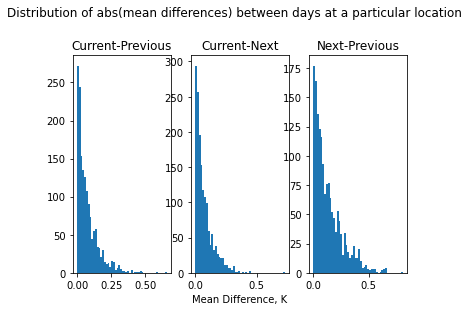

In [20]:
## distribution of mean differences
prev_current = abs((ds.sstL4 - ds.prev_sstL4).mean(dim={'x','y'}))
next_current = abs((ds.sstL4 - ds.next_sstL4).mean(dim={'x','y'}))
prev_next = abs((ds.prev_sstL4 - ds.next_sstL4).mean(dim={'x','y'}))
fig, ax = plt.subplots(1,3)
ax[0].hist(prev_current,bins=50)
ax[0].set_title('Current-Previous')
ax[1].hist(next_current,bins=50)
ax[1].set_title('Current-Next')
ax[1].set_xlabel('Mean Difference, K')
ax[2].hist(prev_next,bins=50)
ax[2].set_title('Next-Previous')
fig.suptitle('Distribution of abs(mean differences) between days at a particular location', y = 1.05)
fig.savefig('plots/prev_next_distribution')